## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [11]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models_v4 import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(280), RandomCrop(224), Normalize(), ToTensor() ])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [14]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size(), sample['image'].device)

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2]) cpu
1 torch.Size([1, 224, 224]) torch.Size([68, 2]) cpu
2 torch.Size([1, 224, 224]) torch.Size([68, 2]) cpu
3 torch.Size([1, 224, 224]) torch.Size([68, 2]) cpu


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [15]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [16]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [17]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [18]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts


#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [19]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [20]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

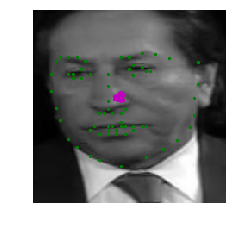

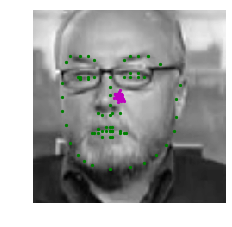

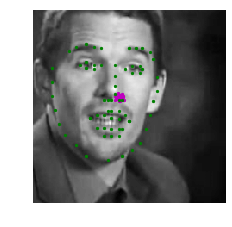

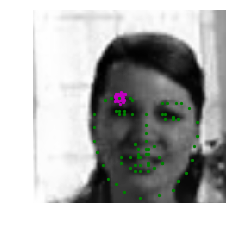

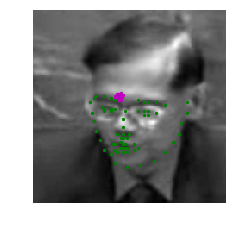

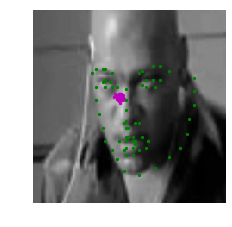

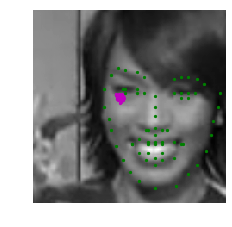

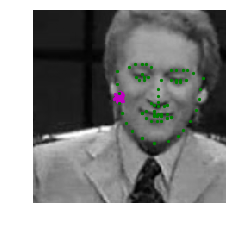

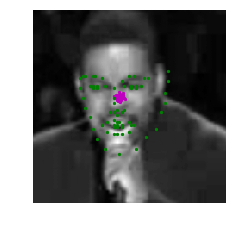

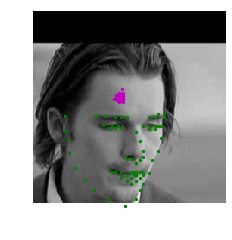

In [21]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    nCol = 5
    for i in range(batch_size):
        plt.figure(figsize=(20,50))
        #ax = plt.subplot(1, batch_size, i+1)
        
        ax = plt.subplot(np.ceil(batch_size/nCol), nCol, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [22]:
if torch.cuda.is_available():
    net = net.cuda() 
    cuda_available = True
    print("GPU power is available.")

GPU power is available.


In [23]:
## TODO: Define the loss and optimization
import torch.optim as optim

if cuda_available:
#     criterion = nn.SmoothL1Loss().cuda()
    criterion = nn.MSELoss().cuda()
else:
    criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(),lr=0.0001)


In [24]:
def cross_validation_error(test_loader):
    tst_running_loss = 0
    for batch_i, data in enumerate(test_loader):
        # get the input images and their corresponding labels
        images = data['image']
        key_pts = data['keypoints']

        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)
        
        if cuda_available:
            images, key_pts = images.cuda(), key_pts.cuda()

        # forward pass to get outputs
        output_pts = net(images)

        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)
        
        # print loss statistics
        tst_running_loss += loss.item()

    return tst_running_loss/batch_i

# test the function
print('Cross Validation Loss = {:.4f}'.format(cross_validation_error(test_loader)))

Cross Validation Loss = 0.8407


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [25]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    tr_counter = 0
    tr_loss_rec_freq = 10
    tr_loss_th = np.zeros((n_epochs*( int(np.floor(len(train_loader)/tr_loss_rec_freq))), 2))
    
    cv_counter = 0
    cv_loss_rec_freq = 100
    cv_loss_th = np.zeros((n_epochs*( int(np.floor(len(train_loader)/cv_loss_rec_freq))), 2))

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        tr_running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            if cuda_available:
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)               
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            tr_running_loss += loss.item()
            if batch_i % tr_loss_rec_freq == tr_loss_rec_freq-1:    # print every 10 batches
                avg_loss = tr_running_loss / (tr_loss_rec_freq )
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                tr_loss_th[tr_counter, :] = np.array([tr_counter, avg_loss])
                tr_running_loss = 0.0
                tr_counter += 1

            if batch_i % cv_loss_rec_freq == cv_loss_rec_freq-1:
                cv_avg_loss = cross_validation_error(test_loader)
                cv_loss_th[cv_counter, :] = np.array([tr_counter, cv_avg_loss])
                print('Epoch: {}, Batch: {}, Avg. Cross-Validation Loss: {:.4f}'.format(epoch + 1, batch_i+1, cv_avg_loss))
                cv_counter += 1
                
                
    print('Finished Training')
    return tr_loss_th, cv_loss_th


In [27]:
# train your network
n_epochs = 50# start small, and increase when you've decided on your model structure and hyperparams

if cuda_available:
    net = net.cuda()
    
tr_loss_th, cv_loss_th = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.22729981541633607
Epoch: 1, Batch: 20, Avg. Loss: 0.25645623058080674
Epoch: 1, Batch: 30, Avg. Loss: 0.24082126840949059
Epoch: 1, Batch: 40, Avg. Loss: 0.19526830986142157
Epoch: 1, Batch: 50, Avg. Loss: 0.17823218032717705
Epoch: 1, Batch: 60, Avg. Loss: 0.24501579031348228
Epoch: 1, Batch: 70, Avg. Loss: 0.1982192575931549
Epoch: 1, Batch: 80, Avg. Loss: 0.3670441508293152
Epoch: 1, Batch: 90, Avg. Loss: 0.2264984130859375
Epoch: 1, Batch: 100, Avg. Loss: 0.2731310412287712
Epoch: 1, Batch: 100, Avg. Cross-Validation Loss: 0.2069
Epoch: 1, Batch: 110, Avg. Loss: 0.18872848600149156
Epoch: 1, Batch: 120, Avg. Loss: 0.21286941394209863
Epoch: 1, Batch: 130, Avg. Loss: 0.19803828671574591
Epoch: 1, Batch: 140, Avg. Loss: 0.2638671413064003
Epoch: 1, Batch: 150, Avg. Loss: 0.2306485131382942
Epoch: 1, Batch: 160, Avg. Loss: 0.3097761064767838
Epoch: 1, Batch: 170, Avg. Loss: 0.17016175910830497
Epoch: 1, Batch: 180, Avg. Loss: 0.1581670381128788
Epoch:

Epoch: 5, Batch: 90, Avg. Loss: 0.08914935551583766
Epoch: 5, Batch: 100, Avg. Loss: 0.1745654743164778
Epoch: 5, Batch: 100, Avg. Cross-Validation Loss: 0.1128
Epoch: 5, Batch: 110, Avg. Loss: 0.12466751597821712
Epoch: 5, Batch: 120, Avg. Loss: 0.16729463934898375
Epoch: 5, Batch: 130, Avg. Loss: 0.10899593383073806
Epoch: 5, Batch: 140, Avg. Loss: 0.1254252791404724
Epoch: 5, Batch: 150, Avg. Loss: 0.1499137096107006
Epoch: 5, Batch: 160, Avg. Loss: 0.1293408267199993
Epoch: 5, Batch: 170, Avg. Loss: 0.0905625082552433
Epoch: 5, Batch: 180, Avg. Loss: 0.12220994755625725
Epoch: 5, Batch: 190, Avg. Loss: 0.08081633374094963
Epoch: 5, Batch: 200, Avg. Loss: 0.07778943367302418
Epoch: 5, Batch: 200, Avg. Cross-Validation Loss: 0.0962
Epoch: 5, Batch: 210, Avg. Loss: 0.09254214353859425
Epoch: 5, Batch: 220, Avg. Loss: 0.08375530168414116
Epoch: 5, Batch: 230, Avg. Loss: 0.14994464404881
Epoch: 5, Batch: 240, Avg. Loss: 0.10380512811243534
Epoch: 5, Batch: 250, Avg. Loss: 0.104638025909

Epoch: 9, Batch: 150, Avg. Loss: 0.08335215859115123
Epoch: 9, Batch: 160, Avg. Loss: 0.07073387689888477
Epoch: 9, Batch: 170, Avg. Loss: 0.11330844424664974
Epoch: 9, Batch: 180, Avg. Loss: 0.072320656478405
Epoch: 9, Batch: 190, Avg. Loss: 0.07371136620640754
Epoch: 9, Batch: 200, Avg. Loss: 0.06914840266108513
Epoch: 9, Batch: 200, Avg. Cross-Validation Loss: 0.0829
Epoch: 9, Batch: 210, Avg. Loss: 0.10382269695401192
Epoch: 9, Batch: 220, Avg. Loss: 0.20068499222397804
Epoch: 9, Batch: 230, Avg. Loss: 0.0848051592707634
Epoch: 9, Batch: 240, Avg. Loss: 0.16882942244410515
Epoch: 9, Batch: 250, Avg. Loss: 0.11357296481728554
Epoch: 9, Batch: 260, Avg. Loss: 0.11284992955625057
Epoch: 9, Batch: 270, Avg. Loss: 0.08155174404382706
Epoch: 9, Batch: 280, Avg. Loss: 0.12168990932404995
Epoch: 9, Batch: 290, Avg. Loss: 0.07265785411000251
Epoch: 9, Batch: 300, Avg. Loss: 0.08605160750448704
Epoch: 9, Batch: 300, Avg. Cross-Validation Loss: 0.1078
Epoch: 9, Batch: 310, Avg. Loss: 0.065395

Epoch: 13, Batch: 200, Avg. Loss: 0.07069669105112553
Epoch: 13, Batch: 200, Avg. Cross-Validation Loss: 0.0758
Epoch: 13, Batch: 210, Avg. Loss: 0.06541808359324933
Epoch: 13, Batch: 220, Avg. Loss: 0.14294554218649863
Epoch: 13, Batch: 230, Avg. Loss: 0.06857147328555584
Epoch: 13, Batch: 240, Avg. Loss: 0.06658172942698001
Epoch: 13, Batch: 250, Avg. Loss: 0.08361022286117077
Epoch: 13, Batch: 260, Avg. Loss: 0.09299927093088627
Epoch: 13, Batch: 270, Avg. Loss: 0.059429144486784935
Epoch: 13, Batch: 280, Avg. Loss: 0.08325758390128613
Epoch: 13, Batch: 290, Avg. Loss: 0.05419313907623291
Epoch: 13, Batch: 300, Avg. Loss: 0.05613403022289276
Epoch: 13, Batch: 300, Avg. Cross-Validation Loss: 0.0683
Epoch: 13, Batch: 310, Avg. Loss: 0.09242509044706822
Epoch: 13, Batch: 320, Avg. Loss: 0.07283850274980068
Epoch: 13, Batch: 330, Avg. Loss: 0.0585852138698101
Epoch: 13, Batch: 340, Avg. Loss: 0.07940968759357929
Epoch: 14, Batch: 10, Avg. Loss: 0.06962058898061514
Epoch: 14, Batch: 20,

Epoch: 17, Batch: 230, Avg. Loss: 0.05710677020251751
Epoch: 17, Batch: 240, Avg. Loss: 0.062235806882381436
Epoch: 17, Batch: 250, Avg. Loss: 0.052300558984279634
Epoch: 17, Batch: 260, Avg. Loss: 0.044712544046342374
Epoch: 17, Batch: 270, Avg. Loss: 0.06280144080519676
Epoch: 17, Batch: 280, Avg. Loss: 0.09847773984074593
Epoch: 17, Batch: 290, Avg. Loss: 0.08226035125553607
Epoch: 17, Batch: 300, Avg. Loss: 0.09396259859204292
Epoch: 17, Batch: 300, Avg. Cross-Validation Loss: 0.0685
Epoch: 17, Batch: 310, Avg. Loss: 0.06717466115951538
Epoch: 17, Batch: 320, Avg. Loss: 0.07679136991500854
Epoch: 17, Batch: 330, Avg. Loss: 0.056813737377524376
Epoch: 17, Batch: 340, Avg. Loss: 0.05020103938877583
Epoch: 18, Batch: 10, Avg. Loss: 0.06320645809173583
Epoch: 18, Batch: 20, Avg. Loss: 0.06726900972425938
Epoch: 18, Batch: 30, Avg. Loss: 0.06399161219596863
Epoch: 18, Batch: 40, Avg. Loss: 0.06226175092160702
Epoch: 18, Batch: 50, Avg. Loss: 0.04945322647690773
Epoch: 18, Batch: 60, Avg

Epoch: 21, Batch: 270, Avg. Loss: 0.07830945625901223
Epoch: 21, Batch: 280, Avg. Loss: 0.061295976117253306
Epoch: 21, Batch: 290, Avg. Loss: 0.061898915097117424
Epoch: 21, Batch: 300, Avg. Loss: 0.0707472551614046
Epoch: 21, Batch: 300, Avg. Cross-Validation Loss: 0.0544
Epoch: 21, Batch: 310, Avg. Loss: 0.06036495771259069
Epoch: 21, Batch: 320, Avg. Loss: 0.20713527202606202
Epoch: 21, Batch: 330, Avg. Loss: 0.0813841126859188
Epoch: 21, Batch: 340, Avg. Loss: 0.07136496342718601
Epoch: 22, Batch: 10, Avg. Loss: 0.05385482329875231
Epoch: 22, Batch: 20, Avg. Loss: 0.046939488500356674
Epoch: 22, Batch: 30, Avg. Loss: 0.062103620916605
Epoch: 22, Batch: 40, Avg. Loss: 0.0535243870690465
Epoch: 22, Batch: 50, Avg. Loss: 0.06215972900390625
Epoch: 22, Batch: 60, Avg. Loss: 0.04872129447758198
Epoch: 22, Batch: 70, Avg. Loss: 0.06593153402209281
Epoch: 22, Batch: 80, Avg. Loss: 0.05134994145482778
Epoch: 22, Batch: 90, Avg. Loss: 0.06337718963623047
Epoch: 22, Batch: 100, Avg. Loss: 0

Epoch: 25, Batch: 300, Avg. Cross-Validation Loss: 0.0598
Epoch: 25, Batch: 310, Avg. Loss: 0.05332351140677929
Epoch: 25, Batch: 320, Avg. Loss: 0.03779956456273794
Epoch: 25, Batch: 330, Avg. Loss: 0.04905169866979122
Epoch: 25, Batch: 340, Avg. Loss: 0.055058366432785985
Epoch: 26, Batch: 10, Avg. Loss: 0.04013091642409563
Epoch: 26, Batch: 20, Avg. Loss: 0.05767056383192539
Epoch: 26, Batch: 30, Avg. Loss: 0.03693445567041635
Epoch: 26, Batch: 40, Avg. Loss: 0.05245725717395544
Epoch: 26, Batch: 50, Avg. Loss: 0.045148764923214915
Epoch: 26, Batch: 60, Avg. Loss: 0.09648072607815265
Epoch: 26, Batch: 70, Avg. Loss: 0.05240827091038227
Epoch: 26, Batch: 80, Avg. Loss: 0.06493632271885871
Epoch: 26, Batch: 90, Avg. Loss: 0.05895387083292007
Epoch: 26, Batch: 100, Avg. Loss: 0.06601531188935042
Epoch: 26, Batch: 100, Avg. Cross-Validation Loss: 0.0613
Epoch: 26, Batch: 110, Avg. Loss: 0.052284879796206954
Epoch: 26, Batch: 120, Avg. Loss: 0.04313297513872385
Epoch: 26, Batch: 130, Avg

Epoch: 29, Batch: 340, Avg. Loss: 0.0635951716452837
Epoch: 30, Batch: 10, Avg. Loss: 0.07013703398406505
Epoch: 30, Batch: 20, Avg. Loss: 0.04845717530697584
Epoch: 30, Batch: 30, Avg. Loss: 0.04794585630297661
Epoch: 30, Batch: 40, Avg. Loss: 0.04218840561807156
Epoch: 30, Batch: 50, Avg. Loss: 0.03632579389959574
Epoch: 30, Batch: 60, Avg. Loss: 0.03960550045594573
Epoch: 30, Batch: 70, Avg. Loss: 0.03369494024664164
Epoch: 30, Batch: 80, Avg. Loss: 0.05778607502579689
Epoch: 30, Batch: 90, Avg. Loss: 0.046239476278424264
Epoch: 30, Batch: 100, Avg. Loss: 0.040808123908936976
Epoch: 30, Batch: 100, Avg. Cross-Validation Loss: 0.0568
Epoch: 30, Batch: 110, Avg. Loss: 0.04553107302635908
Epoch: 30, Batch: 120, Avg. Loss: 0.037984172068536284
Epoch: 30, Batch: 130, Avg. Loss: 0.034902220219373704
Epoch: 30, Batch: 140, Avg. Loss: 0.042553336918354036
Epoch: 30, Batch: 150, Avg. Loss: 0.06432296689599752
Epoch: 30, Batch: 160, Avg. Loss: 0.06357023175805807
Epoch: 30, Batch: 170, Avg. L

Epoch: 34, Batch: 40, Avg. Loss: 0.04864308536052704
Epoch: 34, Batch: 50, Avg. Loss: 0.13588182162493467
Epoch: 34, Batch: 60, Avg. Loss: 0.04504041038453579
Epoch: 34, Batch: 70, Avg. Loss: 0.05296087302267551
Epoch: 34, Batch: 80, Avg. Loss: 0.03828674405813217
Epoch: 34, Batch: 90, Avg. Loss: 0.04715505465865135
Epoch: 34, Batch: 100, Avg. Loss: 0.04509432353079319
Epoch: 34, Batch: 100, Avg. Cross-Validation Loss: 0.0568
Epoch: 34, Batch: 110, Avg. Loss: 0.0316441098228097
Epoch: 34, Batch: 120, Avg. Loss: 0.03602397162467241
Epoch: 34, Batch: 130, Avg. Loss: 0.036911271139979364
Epoch: 34, Batch: 140, Avg. Loss: 0.042210336588323114
Epoch: 34, Batch: 150, Avg. Loss: 0.056706591974943876
Epoch: 34, Batch: 160, Avg. Loss: 0.03915101028978825
Epoch: 34, Batch: 170, Avg. Loss: 0.08446625042706728
Epoch: 34, Batch: 180, Avg. Loss: 0.04655720666050911
Epoch: 34, Batch: 190, Avg. Loss: 0.043560382910072803
Epoch: 34, Batch: 200, Avg. Loss: 0.047646882385015486
Epoch: 34, Batch: 200, Avg

Epoch: 38, Batch: 70, Avg. Loss: 0.06175257656723261
Epoch: 38, Batch: 80, Avg. Loss: 0.04025950729846954
Epoch: 38, Batch: 90, Avg. Loss: 0.05245355702936649
Epoch: 38, Batch: 100, Avg. Loss: 0.13013268653303384
Epoch: 38, Batch: 100, Avg. Cross-Validation Loss: 0.0747
Epoch: 38, Batch: 110, Avg. Loss: 0.06447633616626262
Epoch: 38, Batch: 120, Avg. Loss: 0.04174292776733637
Epoch: 38, Batch: 130, Avg. Loss: 0.10949479229748249
Epoch: 38, Batch: 140, Avg. Loss: 0.06021543852984905
Epoch: 38, Batch: 150, Avg. Loss: 0.05251356884837151
Epoch: 38, Batch: 160, Avg. Loss: 0.33358621411025524
Epoch: 38, Batch: 170, Avg. Loss: 0.10713376738131046
Epoch: 38, Batch: 180, Avg. Loss: 0.05451517179608345
Epoch: 38, Batch: 190, Avg. Loss: 0.05400296039879322
Epoch: 38, Batch: 200, Avg. Loss: 0.057381820119917396
Epoch: 38, Batch: 200, Avg. Cross-Validation Loss: 0.0539
Epoch: 38, Batch: 210, Avg. Loss: 0.048160634376108645
Epoch: 38, Batch: 220, Avg. Loss: 0.04272687304764986
Epoch: 38, Batch: 230

Epoch: 42, Batch: 100, Avg. Cross-Validation Loss: 0.0336
Epoch: 42, Batch: 110, Avg. Loss: 0.0391544284299016
Epoch: 42, Batch: 120, Avg. Loss: 0.077580651268363
Epoch: 42, Batch: 130, Avg. Loss: 0.02965608350932598
Epoch: 42, Batch: 140, Avg. Loss: 0.04165796432644129
Epoch: 42, Batch: 150, Avg. Loss: 0.03593379259109497
Epoch: 42, Batch: 160, Avg. Loss: 0.042054224759340286
Epoch: 42, Batch: 170, Avg. Loss: 0.03480243217200041
Epoch: 42, Batch: 180, Avg. Loss: 0.04247318487614393
Epoch: 42, Batch: 190, Avg. Loss: 0.12491247653961182
Epoch: 42, Batch: 200, Avg. Loss: 0.04312144834548235
Epoch: 42, Batch: 200, Avg. Cross-Validation Loss: 0.0427
Epoch: 42, Batch: 210, Avg. Loss: 0.03641139660030603
Epoch: 42, Batch: 220, Avg. Loss: 0.0351754354313016
Epoch: 42, Batch: 230, Avg. Loss: 0.0553940100595355
Epoch: 42, Batch: 240, Avg. Loss: 0.04272570013999939
Epoch: 42, Batch: 250, Avg. Loss: 0.048995803110301495
Epoch: 42, Batch: 260, Avg. Loss: 0.08607320822775363
Epoch: 42, Batch: 270, 

Epoch: 46, Batch: 130, Avg. Loss: 0.03553397692739964
Epoch: 46, Batch: 140, Avg. Loss: 0.030374255031347275
Epoch: 46, Batch: 150, Avg. Loss: 0.1342918325215578
Epoch: 46, Batch: 160, Avg. Loss: 0.05464745257049799
Epoch: 46, Batch: 170, Avg. Loss: 0.03413171600550413
Epoch: 46, Batch: 180, Avg. Loss: 0.03659204486757517
Epoch: 46, Batch: 190, Avg. Loss: 0.029295826330780983
Epoch: 46, Batch: 200, Avg. Loss: 0.029511222243309022
Epoch: 46, Batch: 200, Avg. Cross-Validation Loss: 0.0389
Epoch: 46, Batch: 210, Avg. Loss: 0.03002110179513693
Epoch: 46, Batch: 220, Avg. Loss: 0.0597864231094718
Epoch: 46, Batch: 230, Avg. Loss: 0.038944697566330434
Epoch: 46, Batch: 240, Avg. Loss: 0.04915515910834074
Epoch: 46, Batch: 250, Avg. Loss: 0.032101441733539106
Epoch: 46, Batch: 260, Avg. Loss: 0.04336970243602991
Epoch: 46, Batch: 270, Avg. Loss: 0.03402937892824411
Epoch: 46, Batch: 280, Avg. Loss: 0.04557028766721487
Epoch: 46, Batch: 290, Avg. Loss: 0.04707410838454962
Epoch: 46, Batch: 300

Epoch: 50, Batch: 170, Avg. Loss: 0.037001106142997744
Epoch: 50, Batch: 180, Avg. Loss: 0.046892080828547476
Epoch: 50, Batch: 190, Avg. Loss: 0.18468458894640208
Epoch: 50, Batch: 200, Avg. Loss: 0.04677847623825073
Epoch: 50, Batch: 200, Avg. Cross-Validation Loss: 0.0579
Epoch: 50, Batch: 210, Avg. Loss: 0.06029571909457445
Epoch: 50, Batch: 220, Avg. Loss: 0.056956243328750135
Epoch: 50, Batch: 230, Avg. Loss: 0.04150678608566523
Epoch: 50, Batch: 240, Avg. Loss: 0.1496903132647276
Epoch: 50, Batch: 250, Avg. Loss: 0.05914623998105526
Epoch: 50, Batch: 260, Avg. Loss: 0.06118497662246227
Epoch: 50, Batch: 270, Avg. Loss: 0.05867183953523636
Epoch: 50, Batch: 280, Avg. Loss: 0.04154206365346909
Epoch: 50, Batch: 290, Avg. Loss: 0.06018504705280066
Epoch: 50, Batch: 300, Avg. Loss: 0.03369858916848898
Epoch: 50, Batch: 300, Avg. Cross-Validation Loss: 0.0435
Epoch: 50, Batch: 310, Avg. Loss: 0.03071782011538744
Epoch: 50, Batch: 320, Avg. Loss: 0.029333151318132876
Epoch: 50, Batch:

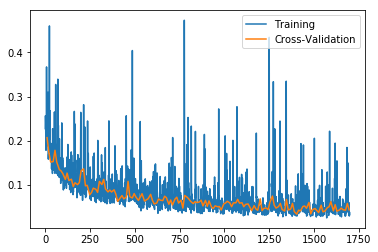

(1700, 2)


In [28]:
# plot training and validation loss
fig = plt.figure()
plt.plot(tr_loss_th[:,0], tr_loss_th[:,1], label='Training')
plt.plot(cv_loss_th[:,0], cv_loss_th[:,1], label='Cross-Validation')

plt.legend()
plt.show()
print(tr_loss_th.shape)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [32]:
# convert net to cpu
net = net.cpu()

# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


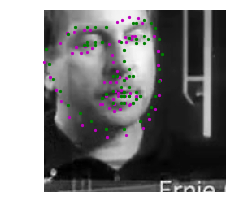

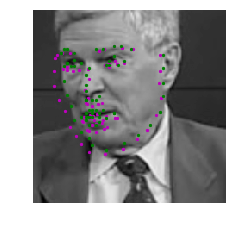

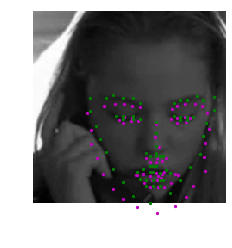

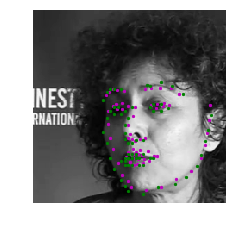

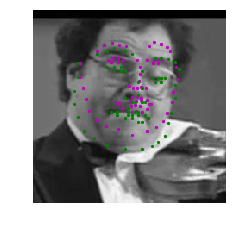

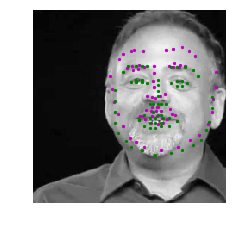

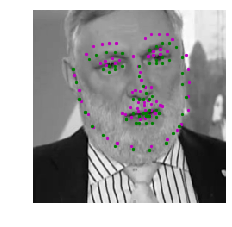

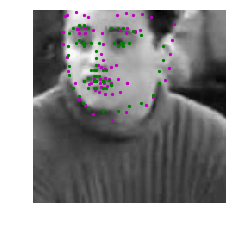

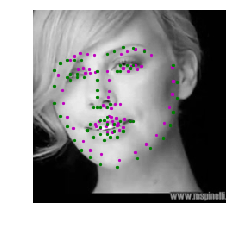

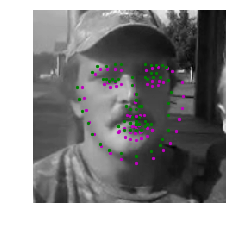

In [34]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [31]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: This being a regression type problem I chose MSE (Mean Squared Error) loss function. Adam optimizer was chose due to its adaptive capabilities. To objectively quantify the learning behavior training loss and cross-validation loss were monitored over different epoch. Decreasing training loss ensured that the learning rate was not too high and decreading cross-validation loss ensured that the model was not over-fitting.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with 4 conv layers where each layer was followed by a maxpool layer and batch-normalization. All this was followed by 3 fully connected layer. The network performance was moderate and although cross-validation did not diverge during the 30 epochs thraining, the prediction for different images seemed awfully close while testing. This seemed like no matter what it is providing the similar keypoint estimation for every image. I decided to add more learnable parameters by adding more conv layers and reduced the number of maxpooling operations. I also increased the filter size for initial few layers as I wanted to increase the field of view for these layers.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I trained using a GPU with modest memory size, hence I had to stick with lower batch size. Also using smaller batch size helped fine grained adjustment of trainable parameters during training. Training and cross-validation error were monitored suring the training to make sure that there is no over fitting happening during the training. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

32


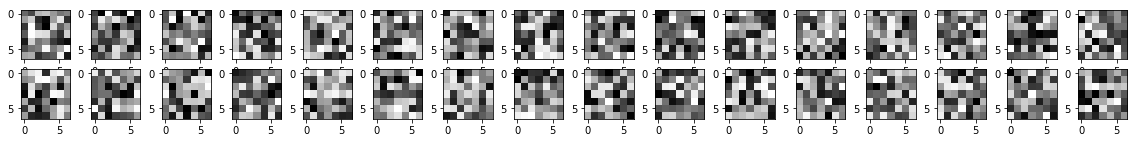

In [71]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

print(w.shape[0])
n_row = np.ceil(w.shape[0]/16)
plt.figure(figsize=(20,n_row))
for i in range(w.shape[0]):
    plt.subplot(n_row,16,i+1)
    filter_index = i

#     print(w[filter_index][0])
#     print(w[filter_index][0].shape)

    # display the filter weights
    plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

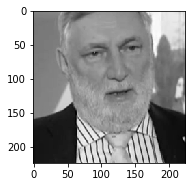

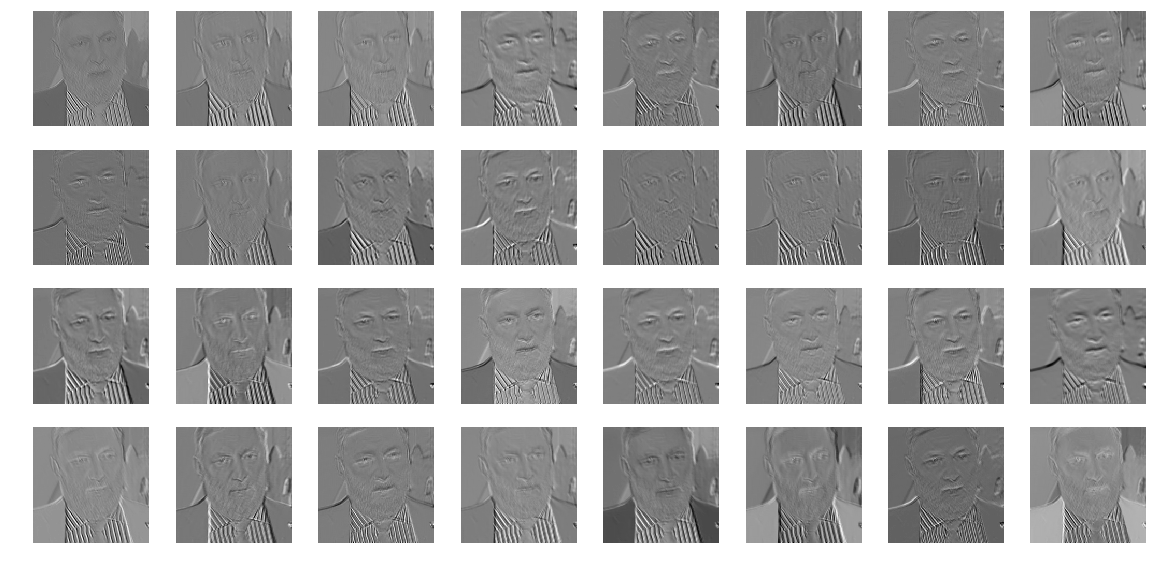

In [73]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
image_for_filt = test_images[6].data   # get the image from it's Variable wrapper
image_for_filt = image_for_filt.numpy()   # convert to numpy array from a Tensor
image_for_filt = np.transpose(image_for_filt, (1, 2, 0))   # transpose to go from torch to numpy image

## TODO: Using cv's filter2D function,
import cv2

## apply a specific set of filter weights (like the one displayed above) to the test image
plt.figure()
plt.subplot(121)
plt.imshow(np.squeeze(image_for_filt),cmap="gray")
plt.figure(figsize=(20,20))
for i in range(32):
    filtered = cv2.filter2D(image_for_filt,-1,w[i][0])
    plt.subplot(8,8,i+1)
    plt.imshow(filtered,cmap="gray")
    plt.axis('off')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The filter shown below (23rd filter) detects the horizontal lines in the the image.

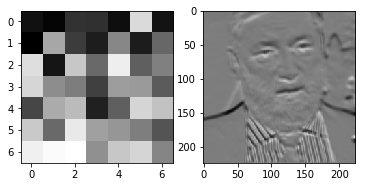

In [78]:
plt.subplot(121)
plt.imshow(w[23][0], cmap='gray')

plt.subplot(122)
filtered = cv2.filter2D(image_for_filt,-1,w[23][0])
plt.imshow(filtered, cmap='gray')

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!